In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
import os
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset

from fastai.basic_train import Learner
from fastai import train
from fastai.basic_data import DataBunch
from fastai.callbacks import EarlyStoppingCallback

from dataloader.toy import ToySinData, ToyQubicData
from model.dense import Dense
from uncertainty_estimator.masks import build_masks, DEFAULT_MASKS
from experiment_setup import build_estimator
from experiments.utils.fastai import ImageArrayDS

# Config
config = {
    'use_cache': False,
    'layers': [1, 128, 128, 64, 1],
    'batch_size': 2,
    'retrain': True,
    'nn_runs': 100,
    'dropout_uq': 0.5,
    'patience': 50
}



In [3]:
plt.rcParams['figure.facecolor'] = 'white'

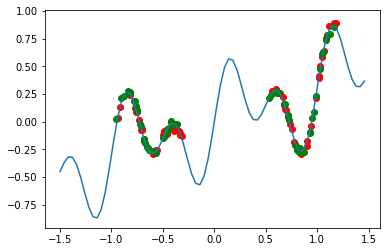

In [4]:
# Import data

data_class = ToySinData
# data_class = ToyQubicData

x_train, y_train = data_class(use_cache=config['use_cache']).dataset('train')
x_val, y_val = data_class(use_cache=config['use_cache']).dataset('val')
x_true, y_true = data_class().dataset('ground_truth')

plt.plot(x_true, y_true)
plt.scatter(x_train, y_train, color='red')
plt.scatter(x_val, y_val, color='green')

train_ds = TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
val_ds = TensorDataset(torch.FloatTensor(x_val), torch.FloatTensor(y_val))
data = DataBunch.create(train_ds, val_ds, bs=config['batch_size'])


In [5]:
# Train model
model = Dense(config['layers']).float()
loss_func = torch.nn.MSELoss()
callback_fns=[partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=1e-3, patience=config['patience'])]
learner = Learner(data, model, loss_func=loss_func, callback_fns=callback_fns)

model_path = "data/model_masks.pt"
if config['retrain'] or not os.path.exists(model_path):
    learner.fit_one_cycle(50, 5e-3, wd=1e-3, div_factor=10)
    torch.save(model.state_dict(), model_path)
else:
    model.load_state_dict(torch.load(model_path))


epoch     train_loss  valid_loss  time    
      0         0.097808    0.078109    00:00     
      1         0.086803    0.083955    00:00     
      2         0.079313    0.076289    00:00     
      3         0.081139    0.072521    00:00     
      4         0.071594    0.066600    00:00     
      5         0.084070    0.085886    00:00     
      6         0.083154    0.178384    00:00     
      7         0.133249    0.086487    00:00     
      8         0.107627    0.068669    00:00     
      9         0.087480    0.062001    00:00     
      10        0.078796    0.070176    00:00     
      11        0.065762    0.052212    00:00     
      12        0.057254    0.051066    00:00     
      13        0.050692    0.064238    00:00     
      14        0.050696    0.057867    00:00     
      15        0.049734    0.053955    00:00     
      16        0.049176    0.042235    00:00     
      17        0.042667    0.040031    00:00     
      18        0.040011    0.039427   

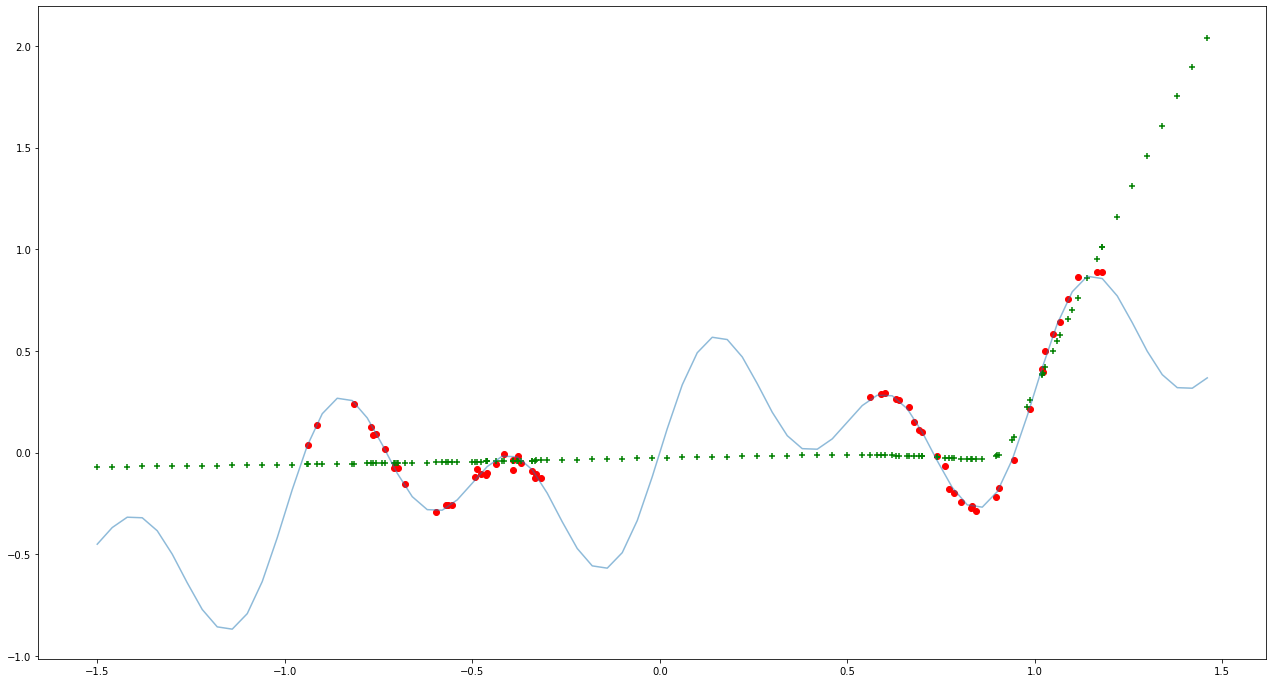

In [6]:

model.eval()

x_ = np.concatenate((x_true, x_train))
x_tensor = torch.FloatTensor(x_).to('cuda')
x_true_tensor = torch.FloatTensor(x_true).to('cuda')
y_ = model(x_tensor).detach().cpu().numpy()
plt.figure(figsize=(22, 12))
plt.plot(x_true, y_true, alpha=0.5)
plt.scatter(x_train, y_train, color='red')
plt.scatter(x_, y_, color='green', marker='+')


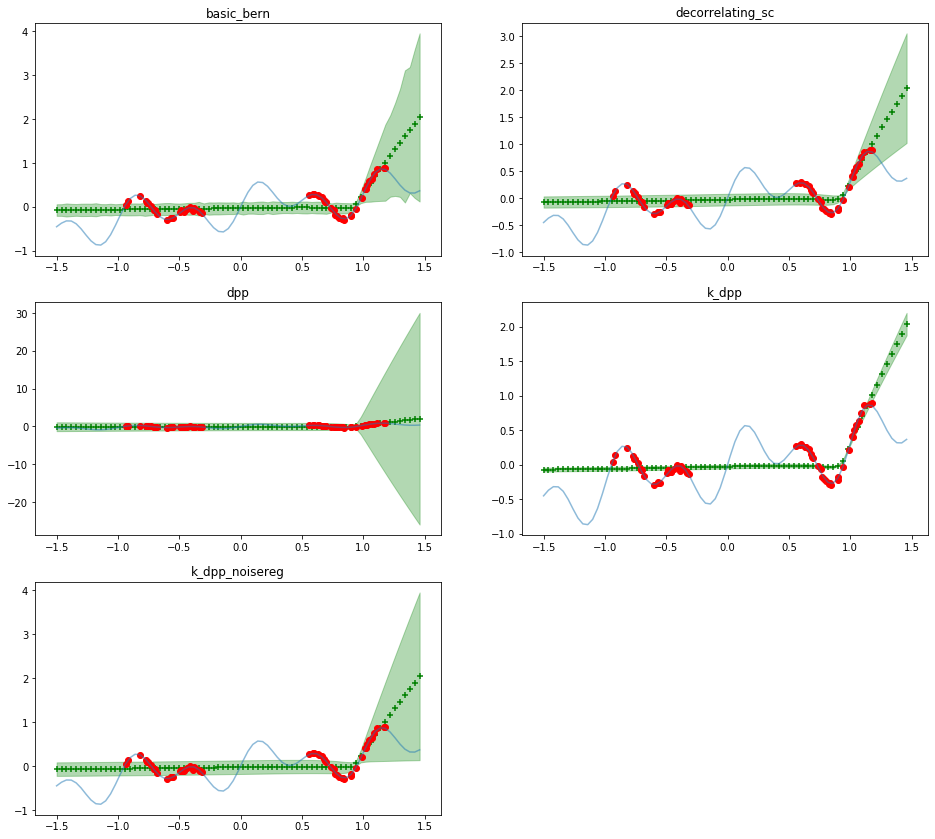

In [7]:
masks = build_masks(DEFAULT_MASKS)
y_pred = model(x_true_tensor).detach().cpu().numpy()

def make_uq_graph(name, estimations):
    plt.title(name)
    plt.plot(x_true, y_true, alpha=0.5)
    plt.scatter(x_true, y_pred, color='green', marker='+')
    plt.fill_between(np.ravel(x_true), np.ravel(y_pred) - estimations, np.ravel(y_pred) + estimations, alpha=0.3,
                     color='green')
    plt.scatter(x_train, y_train, color='red')


dropout_runs = {}

plt.figure(figsize=(16, 30))
for i, (name, mask) in enumerate(masks.items()):
    if hasattr(mask, 'reset'):
        mask.reset()
    estimator = build_estimator(
        'mcdue_masked', model, keep_runs=True, nn_runs=config['nn_runs'],
        dropout_mask=mask, dropout_rate=config['dropout_uq'])

    estimations = estimator.estimate(x_true_tensor)
    dropout_runs[name] = estimator.last_mcd_runs()
    plt.subplot(6, 2, i + 1)
    make_uq_graph(name, estimations)


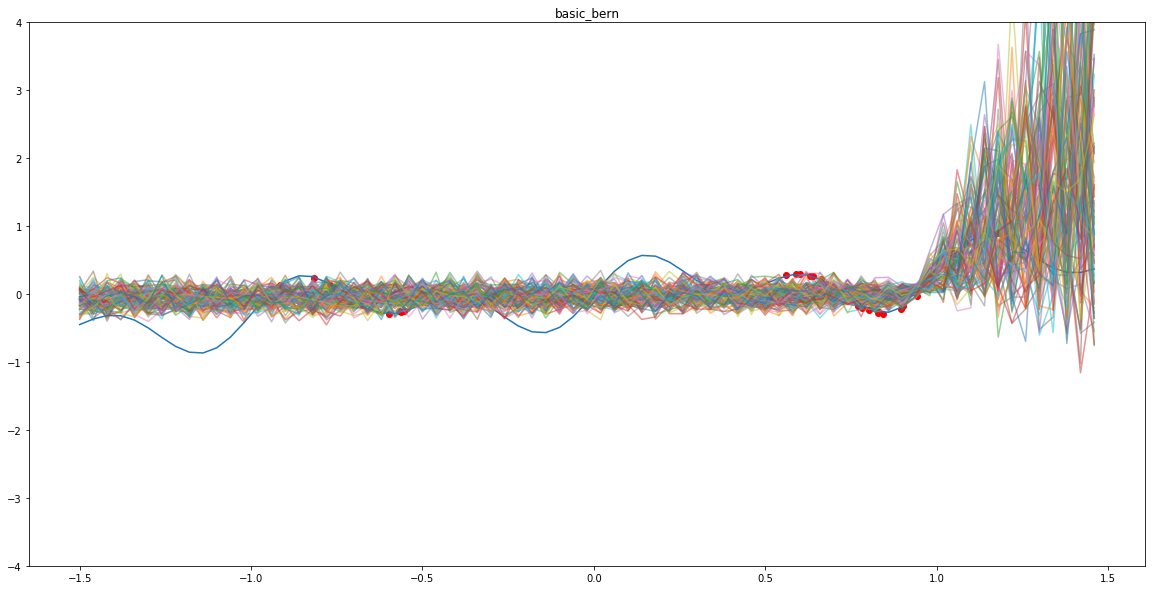

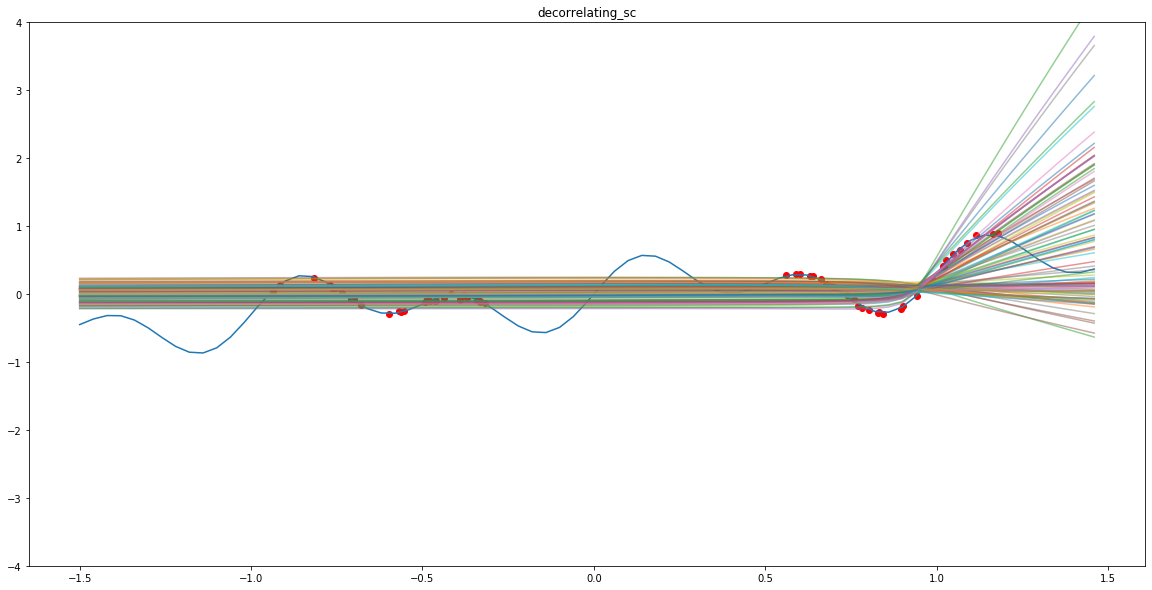

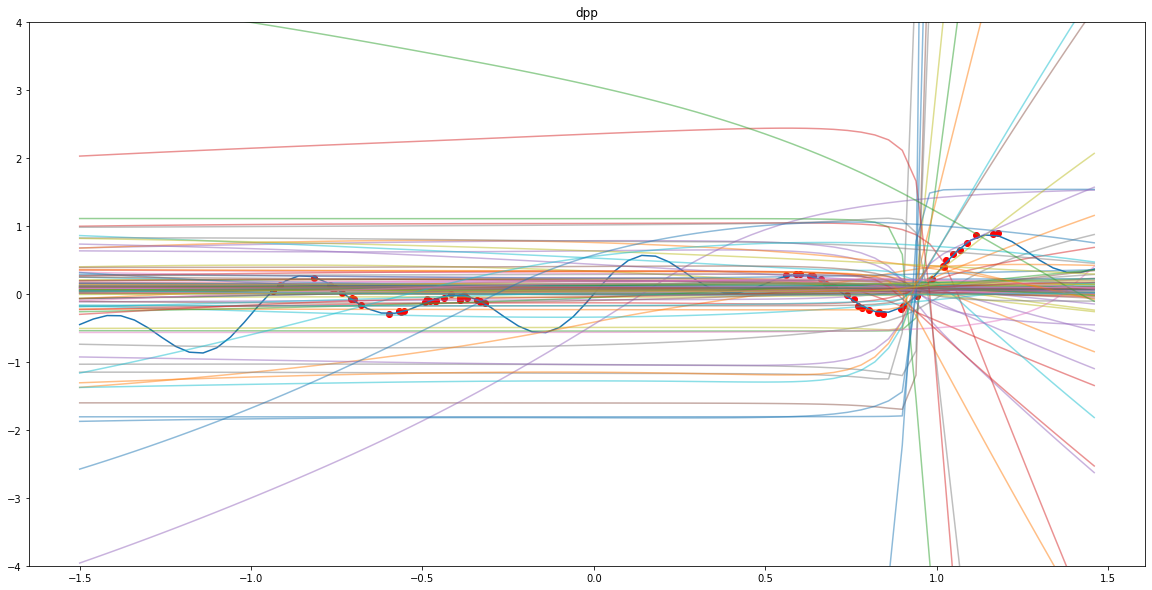

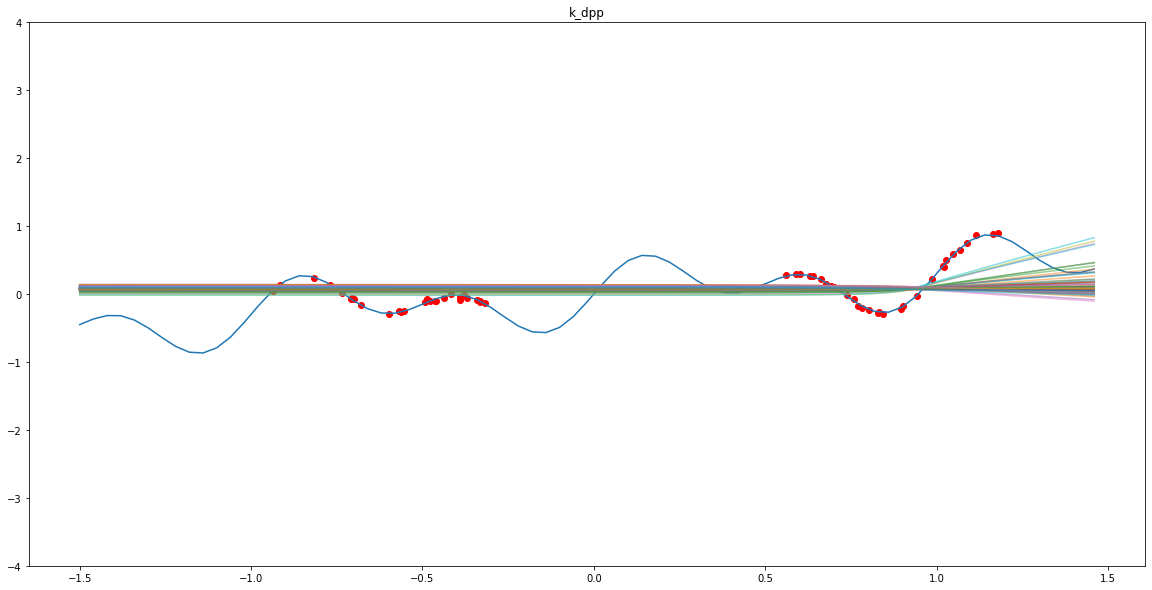

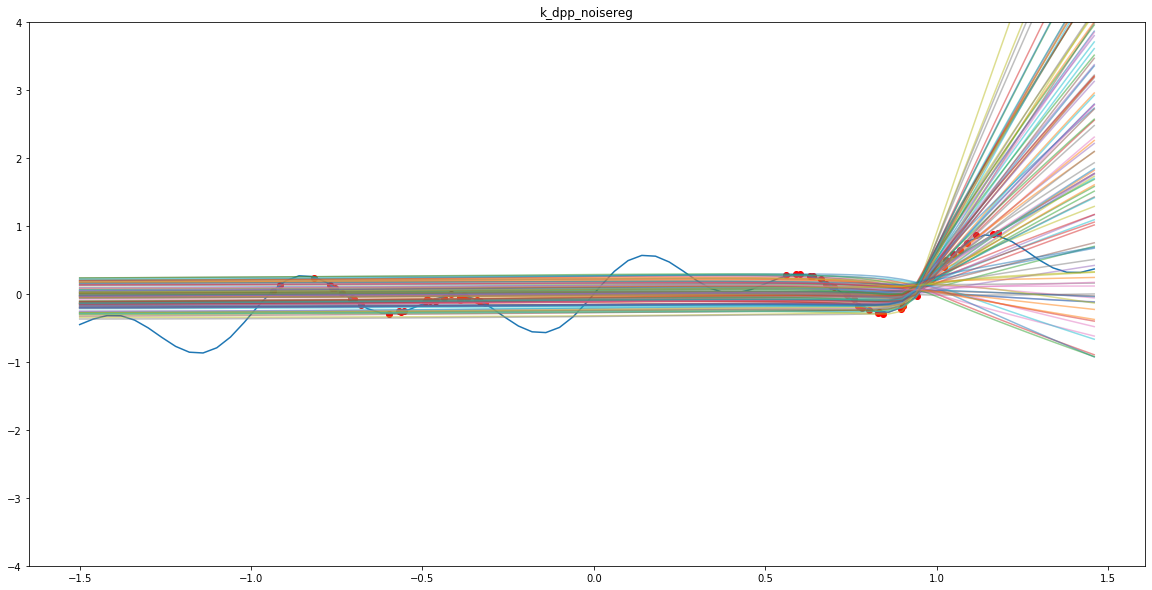

In [8]:
### Dropout predictions
def plot_dropout_runs(name, predictions, n=50):
    plt.figure(figsize=(20, 10))
    plt.title(name)
    plt.plot(x_true, y_true)
    plt.scatter(x_train, y_train, color='red')
    axes = plt.gca()
    axes.set_ylim([-4, 4])
    for prediction_line in predictions[:n]:
        plt.plot(x_true, prediction_line, alpha=0.5)
    plt.show()


for name, runs in dropout_runs.items():
    plot_dropout_runs(name, runs.T, 200)



In [9]:
### Print sampling
dpp = masks[list(masks.keys())[-1]]
samples = dpp.dpps[0].list_of_samples
lengths = [len(sample) for sample in samples]
print(sum(lengths) / len(lengths) / config['layers'][1])
samples



0.4952815594059406


[[10, 67, 98],
 [54,
  76,
  84,
  38,
  51,
  125,
  86,
  122,
  89,
  18,
  36,
  62,
  67,
  104,
  106,
  34,
  78,
  6,
  21,
  80,
  111,
  12,
  29,
  52,
  60,
  28,
  105,
  13,
  56,
  44,
  2,
  47,
  50,
  5,
  24,
  10,
  4,
  19,
  46,
  1,
  77,
  0,
  11,
  14,
  99,
  63,
  23,
  107,
  113,
  26,
  69,
  59,
  73,
  123,
  127,
  102,
  8,
  40,
  115,
  118,
  66,
  74,
  7,
  57],
 [16,
  30,
  97,
  7,
  34,
  56,
  78,
  96,
  50,
  79,
  121,
  120,
  72,
  112,
  94,
  36,
  25,
  63,
  125,
  52,
  22,
  37,
  60,
  101,
  99,
  58,
  43,
  68,
  123,
  11,
  66,
  122,
  10,
  119,
  109,
  88,
  18,
  51,
  42,
  54,
  85,
  80,
  26,
  124,
  76,
  103,
  21,
  86,
  113,
  117,
  27,
  48,
  95,
  74,
  59,
  0,
  45,
  29,
  83,
  65,
  47,
  115,
  19,
  81],
 [95,
  106,
  118,
  114,
  69,
  46,
  4,
  111,
  36,
  86,
  65,
  54,
  105,
  56,
  53,
  75,
  125,
  121,
  99,
  51,
  9,
  28,
  61,
  37,
  67,
  112,
  38,
  50,
  26,
  32,
  52,
  89,
